In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import math
import numpy as np
import random
import collections
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image

In [3]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

array([ 0.0473053 , -0.00553573,  0.00217591, -0.02054415])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
EPISODES = 500
LR = 0.001
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
HIDDEN_LAYER1 = 128
HIDDEN_LAYER2 = 32
BATCH_SIZE = 64
NUM_ACTIONS = 2
NUM_OBS = 4
LIMIT = 10000
STEPS = 0
TARGET_UPDATE = 10
EPISODE_DURATION = []
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

In [6]:
class Replaymemory():
    def __init__(self, limit):
        self.limit = limit
        self.memory = []
        self.index = 0
    
    def push(self, transition):
        if(len(self.memory) < self.limit):
            self.memory.append(None)
        self.memory[self.index] = transition
        # the memory acts like a cyclic buffer
        self.index = (self.index + 1) % self.limit
        
    def sample(self, batch_size):
        # randomly samples from the memory
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.ln0 = nn.Linear(NUM_OBS, HIDDEN_LAYER1)
        self.ln1 = nn.Linear(HIDDEN_LAYER1, HIDDEN_LAYER2)
        self.ln2 = nn.Linear(HIDDEN_LAYER2, NUM_ACTIONS)
    
    def forward(self, x):
        x = F.relu(self.ln0(x))
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x

In [8]:
def epsilon_greedy_policy(state):
    global STEPS
    # decreasing epsilon
    eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * STEPS / EPS_DECAY)
    prob = random.random()
    STEPS += 1
    if(prob > eps):
        action = policy_model(state).max(0)[1]
    else:
        action = torch.tensor(random.randrange(NUM_ACTIONS))
    return action

In [9]:
def optimize():
    if(len(memory) < BATCH_SIZE):
        print('not enough samples available')
        return 
    batch = memory.sample(BATCH_SIZE)
    
    curr_state_batch, curr_action_batch, next_state_batch, reward_batch = zip(*batch)
    
    is_non_terminating = torch.tensor(tuple(map(lambda s: s is not None, next_state_batch)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in next_state_batch if s is not None])
    
    curr_state_batch = torch.cat(curr_state_batch)
    
    curr_action_batch = torch.cat(curr_action_batch)
    
    next_state_batch = torch.cat(next_state_batch)
    
    reward_batch = torch.cat(reward_batch)
    
    curr_q_vals = policy_model(curr_state_batch).gather(1,curr_action_batch.long().reshape(BATCH_SIZE,1))
    
    curr_q_vals = curr_q_vals.reshape(1,BATCH_SIZE)[0]
    
    next_q_vals = torch.zeros(BATCH_SIZE)
        
    next_q_vals[is_non_terminating] = target_model(non_final_next_states).max(1)[0].detach()
    
    max_q_vals = reward_batch + GAMMA * next_q_vals
    
    loss = F.smooth_l1_loss(curr_q_vals,max_q_vals)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    for param in policy_model.parameters():
        param.grad.data.clamp_(-1, 1)
    return loss.item()

In [10]:
policy_model = Network()
target_model = Network()

target_model.load_state_dict(policy_model.state_dict())
target_model.eval()

optimizer = optim.Adam(policy_model.parameters(), lr=LR)
memory = Replaymemory(LIMIT)

In [11]:
def plot_durations():
    plt.figure(figsize=(15,10))
    plt.xlabel('EPISODE')
    plt.ylabel('DURATION')
    plt.plot(EPISODE_DURATION)
    plt.grid()
    plt.show()

In [12]:
net_reward = 0
for episode in range(EPISODES):
    
    curr_state = env.reset()
    max_loss = 0
    time_in_episode = 0
    
    while True:
        env.render()
        
        time_in_episode += 1
        
        curr_action = epsilon_greedy_policy(FloatTensor(curr_state))
        
        next_state, reward, done, info = env.step(int(curr_action))
        
        memory.push((FloatTensor([curr_state]), FloatTensor([curr_action]), FloatTensor([next_state]), FloatTensor([reward])))
        
        loss = optimize()
        
        if loss is not None and loss > max_loss:
            max_loss = loss
        
        net_reward += reward
        
        curr_state = next_state
        
        if done:
            EPISODE_DURATION.append(time_in_episode)
            print(f'Maximum loss in episode {episode}: {max_loss}')
            print(f'Episode length: {time_in_episode}')
            print('\n')
            break
    
    if not episode % TARGET_UPDATE:
        target_model.load_state_dict(policy_model.state_dict())
        print(f'Mean reward for episode {episode}: {net_reward/TARGET_UPDATE}')
        net_reward = 0

print('COMPLETE')
env.render()
env.close()

not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
Maximum loss in episode 0: 0
Episode length: 28


Mean reward for episode 0: 2.8
not enough samples available
not enough samples available
not enough samples available
not enough samples a

Maximum loss in episode 89: 0.0010384094202890992
Episode length: 9


Maximum loss in episode 90: 0.0008705444633960724
Episode length: 9


Mean reward for episode 90: 9.2
Maximum loss in episode 91: 0.5946826934814453
Episode length: 10


Maximum loss in episode 92: 0.1389506310224533
Episode length: 9


Maximum loss in episode 93: 0.06679977476596832
Episode length: 10


Maximum loss in episode 94: 0.027552546933293343
Episode length: 9


Maximum loss in episode 95: 0.008876762352883816
Episode length: 10


Maximum loss in episode 96: 0.004237316083163023
Episode length: 9


Maximum loss in episode 97: 0.002360024955123663
Episode length: 9


Maximum loss in episode 98: 0.001430801465176046
Episode length: 12


Maximum loss in episode 99: 0.0012980217579752207
Episode length: 10


Maximum loss in episode 100: 0.0012310098391026258
Episode length: 9


Mean reward for episode 100: 9.7
Maximum loss in episode 101: 0.6165883541107178
Episode length: 10


Maximum loss in episode 102: 0.19

Maximum loss in episode 201: 1.1064199209213257
Episode length: 12


Maximum loss in episode 202: 0.1757992058992386
Episode length: 9


Maximum loss in episode 203: 0.06874332576990128
Episode length: 10


Maximum loss in episode 204: 0.026012178510427475
Episode length: 10


Maximum loss in episode 205: 0.012668604962527752
Episode length: 9


Maximum loss in episode 206: 0.00691940076649189
Episode length: 10


Maximum loss in episode 207: 0.003289199201390147
Episode length: 11


Maximum loss in episode 208: 0.002302135806530714
Episode length: 9


Maximum loss in episode 209: 0.0016437263693660498
Episode length: 8


Maximum loss in episode 210: 0.0018446677131578326
Episode length: 9


Mean reward for episode 210: 9.7
Maximum loss in episode 211: 1.1922615766525269
Episode length: 10


Maximum loss in episode 212: 0.4155638813972473
Episode length: 9


Maximum loss in episode 213: 0.1203434020280838
Episode length: 8


Maximum loss in episode 214: 0.08161479234695435
Episode leng

Maximum loss in episode 314: 0.12821286916732788
Episode length: 10


Maximum loss in episode 315: 0.03585213050246239
Episode length: 9


Maximum loss in episode 316: 0.016056163236498833
Episode length: 10


Maximum loss in episode 317: 0.014009679667651653
Episode length: 10


Maximum loss in episode 318: 0.021570395678281784
Episode length: 8


Maximum loss in episode 319: 0.015718862414360046
Episode length: 11


Maximum loss in episode 320: 0.018893782049417496
Episode length: 10


Mean reward for episode 320: 10.1
Maximum loss in episode 321: 2.596810817718506
Episode length: 11


Maximum loss in episode 322: 1.0967674255371094
Episode length: 10


Maximum loss in episode 323: 0.21135106682777405
Episode length: 9


Maximum loss in episode 324: 0.1004180908203125
Episode length: 8


Maximum loss in episode 325: 0.05359703302383423
Episode length: 9


Maximum loss in episode 326: 0.03454601764678955
Episode length: 9


Maximum loss in episode 327: 0.018800582736730576
Episode len

Maximum loss in episode 428: 0.1597491353750229
Episode length: 9


Maximum loss in episode 429: 0.20589907467365265
Episode length: 9


Maximum loss in episode 430: 0.20494544506072998
Episode length: 9


Mean reward for episode 430: 9.2
Maximum loss in episode 431: 4.631653308868408
Episode length: 9


Maximum loss in episode 432: 2.66219425201416
Episode length: 9


Maximum loss in episode 433: 1.0844638347625732
Episode length: 9


Maximum loss in episode 434: 0.583450198173523
Episode length: 10


Maximum loss in episode 435: 0.25422677397727966
Episode length: 9


Maximum loss in episode 436: 0.24270741641521454
Episode length: 9


Maximum loss in episode 437: 0.2725161015987396
Episode length: 9


Maximum loss in episode 438: 0.18930716812610626
Episode length: 10


Maximum loss in episode 439: 0.19908173382282257
Episode length: 10


Maximum loss in episode 440: 0.2917664647102356
Episode length: 9


Mean reward for episode 440: 9.3
Maximum loss in episode 441: 5.42157030105590

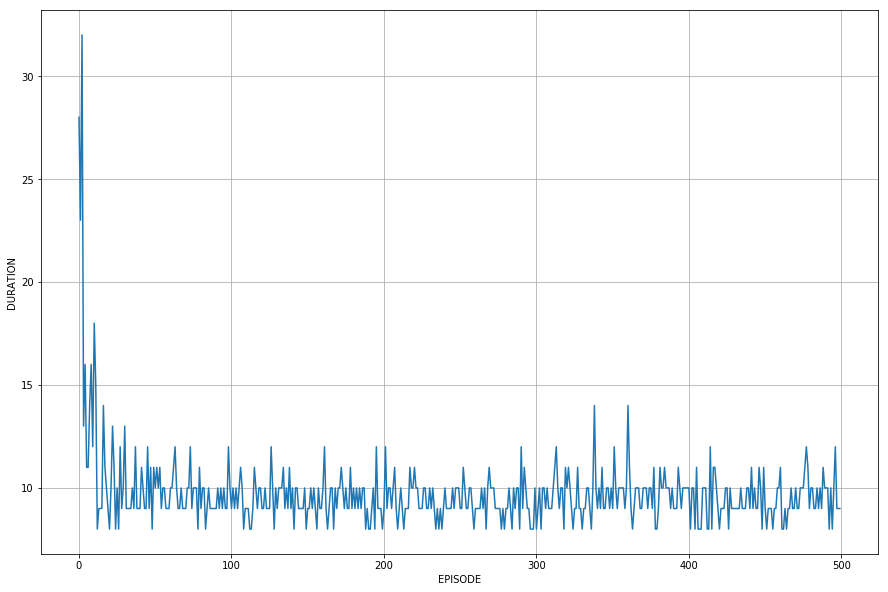

In [13]:
plot_durations()